## Train classifier by layers

This notebook trains a classifier that operates in two layers:
- First we use a SVM classifier to label utterances with high degree of certainty.
- Afterwards we use heuristics to complete the labeling

### Import and path definition

In [1]:
import os
import pandas as pd
import numpy as np
import random
import pickle
import sys
import matplotlib.pyplot as plt

root_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
sys.path.append(root_path)

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from src import phase_classification as pc

data_path = os.path.join(root_path,'data')
tables_path = os.path.join(data_path,'tables')

### Load data

In [2]:
WITH_STEMMING = True
#REMOVE_STOPWORDS = True
SEED = 10
NUM_TOPICS = 60
random.seed(SEED)
CLASS_W = False

In [3]:
file_name = '[train]IBL_topic_distribution_by_utterance_with_phrase_before_and_after_time_utterance_minimum_0_words_with_stemming_{}_{}.xlsx'.format(WITH_STEMMING,NUM_TOPICS)
df_data = pd.read_excel(os.path.join(tables_path,'train',file_name))

In [4]:
df_data.head()

,Topic before 1,Topic before 2,Topic before 3,Topic before 4,Topic before 5,Topic before 6,Topic before 7,Topic before 8,Topic before 9,Topic before 10,...,Topic after 60,phase,phase_1,phase_2,phase_3,phase_4,phase_5,utterance,length utterance,utterance_relative_time
0,0.028715,0.012903,0.006044,0.005848,0.005266,0.057161,0.007285,0.004799,0.006815,0.008096,...,0.005848,1,1,0,0,0,0,SATUNNAINEN,0.000000,0.000000
1,0.028715,0.012903,0.006044,0.005848,0.005266,0.057161,0.007285,0.004799,0.006815,0.008096,...,0.005848,1,1,0,0,0,0,siel QUESTION_SYMBOL onks oo palo,0.065574,0.010417
2,0.025757,0.010554,0.004944,0.004783,0.004307,0.107424,0.005959,0.003926,0.005574,0.006622,...,0.005215,1,1,0,0,0,0,no tää varm muutu,0.049180,0.017361
3,0.023489,0.010554,0.004944,0.004783,0.004307,0.054591,0.005959,0.003926,0.005574,0.006622,...,0.003782,1,1,0,0,0,0,aja T_ ATOMI ehtiny törm ton ver,0.098361,0.020833
4,0.021241,0.009412,0.004409,0.004266,0.003841,0.045906,0.059203,0.003501,0.004971,0.005906,...,0.007721,1,1,0,0,0,0,ton ver ai pitä muute kato sil taas oo lask to...,0.213115,0.027778


In [5]:
the_keys = list(set(df_data['phase']))
total_samples = 0
class_samples = {}
for key in the_keys:
    n = list(df_data.phase.values).count(key)
    #print("key {}, total {}".format(key,n))
    total_samples += n
    class_samples[key] = n
print(total_samples)
for key in the_keys:
    print("key {}, samples: {}, prop: {}".format(key,class_samples[key],round(class_samples[key]*1.0/total_samples,2)))

1600
key 1, samples: 403, prop: 0.25
key 2, samples: 175, prop: 0.11
key 3, samples: 406, prop: 0.25
key 4, samples: 62, prop: 0.04
key 5, samples: 554, prop: 0.35


### split data

In [6]:
filter_rows = list(range(180))+[187,188]
row_label = 180

In [7]:
dfs_train,dfs_val = pc.split_df_discussions(df_data,.2,SEED)
X_train,y_train = pc.get_joined_data_from_df(dfs_train,filter_rows,row_label)
X_val,y_val = pc.get_joined_data_from_df(dfs_val,filter_rows,row_label)
len(X_train)

1328

In [8]:
dfs_all,_ = pc.split_df_discussions(df_data,.0,SEED)
X_all,y_all = pc.get_joined_data_from_df(dfs_all,filter_rows,row_label)

In [9]:
len(X_train[0])

182

### Classify first layer

In [10]:
class_weight = {}
for key in the_keys:
    class_weight[key] = 1000.0/class_samples[key]

In [11]:
if CLASS_W:
    svc = SVC(kernel='linear',random_state=SEED,max_iter=3000,probability=True,class_weight=class_weight)
else:
    svc = SVC(kernel='linear',random_state=SEED,max_iter=3000,probability=True)#,class_weight=class_weight)
svc.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svc.score(X_val, y_val)))

Accuracy of SVM classifier on training set: 0.51
Accuracy of SVM classifier on test set: 0.57


In [12]:
pred = svc.predict(X_val)
labels = ["Phase {}".format(i) for i in range(1,6)]
df = pd.DataFrame(confusion_matrix(y_val, pred),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
#print(" ")
print(classification_report(y_val, pred))
df

              precision    recall  f1-score   support

           1       0.72      0.61      0.66       101
           2       0.00      0.00      0.00         9
           3       0.86      0.10      0.17        63
           4       0.00      0.00      0.00         3
           5       0.49      0.91      0.63        96

   micro avg       0.57      0.57      0.57       272
   macro avg       0.41      0.32      0.29       272
weighted avg       0.64      0.57      0.51       272



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,62,0,1,0,38
Phase 2,0,0,0,0,9
Phase 3,15,0,6,0,42
Phase 4,0,0,0,0,3
Phase 5,9,0,0,0,87


### Find threshold

Look for the distance to the second max

In [13]:
pred_val = svc.predict_proba(X_val)
prob_pred = [v[int(y_val[i]-1)] for i,v in enumerate(pred_val)]

(array([26., 30., 33., 36., 26., 40., 36., 30.,  8.,  7.]),
 array([0.0313363 , 0.11093981, 0.19054333, 0.27014684, 0.34975035,
        0.42935386, 0.50895737, 0.58856089, 0.6681644 , 0.74776791,
        0.82737142]),
 <a list of 10 Patch objects>)

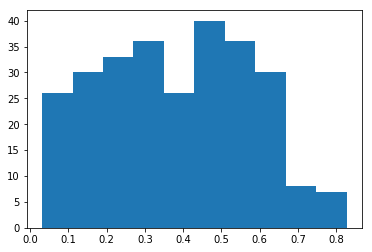

In [14]:
plt.hist(prob_pred)

In [15]:
tuple_winner_pred = [(np.max(v),prob_pred[i],np.max(v)==prob_pred[i]) for i,v in enumerate(pred_val)]
values_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==True]
values_not_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==False]
values_dist_not_ok = [v[0]-v[1] for i,v in enumerate(tuple_winner_pred) if v[2]==False]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,
         2.,  5.,  1.,  4.,  5.,  7.,  4.,  0., 10.,  3.,  7.,  4.,  5.,
         2.,  1.,  4.,  2.,  3.,  1.,  8.,  3.,  2.,  2.,  4.,  3.,  6.,
         1.,  2.,  1.,  2.,  1.,  0.,  0.,  4.,  0.,  3.,  1.,  1.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ,
        0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41,
        0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52,
        0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63,
        0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74,
        0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
        0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94]),
 <a list of 74 Patch objects>)

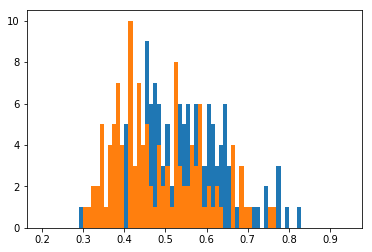

In [16]:
plt.hist(values_ok,np.arange(0.2,.95,.01))
plt.hist(values_not_ok,np.arange(0.2,.95,.01))

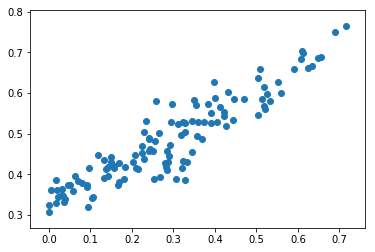

In [17]:
plt.scatter(values_dist_not_ok,values_not_ok)

Define Threshold 

In [18]:
t = 0.45

In [19]:
df_data.columns

Index(['Topic before 1', 'Topic before 2', 'Topic before 3', 'Topic before 4',
       'Topic before 5', 'Topic before 6', 'Topic before 7', 'Topic before 8',
       'Topic before 9', 'Topic before 10',
       ...
       'Topic after 60', 'phase', 'phase_1', 'phase_2', 'phase_3', 'phase_4',
       'phase_5', 'utterance', 'length utterance', 'utterance_relative_time'],
      dtype='object', length=189)

In [20]:
output_first_layer = pc.first_layer_classifier(X_all,t,svc)
comparison = list(zip(output_first_layer,y_all))

(array([540.,   0.,   0., 311.,   0.,  27., 158.,   0.,   0., 564.]),
 array([-1. , -0.4,  0.2,  0.8,  1.4,  2. ,  2.6,  3.2,  3.8,  4.4,  5. ]),
 <a list of 10 Patch objects>)

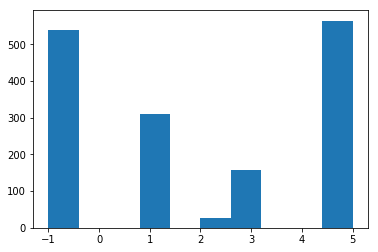

In [21]:
plt.hist(output_first_layer)

In [22]:
df_data['first_layer'] = output_first_layer

### Second layer

In [23]:
second_layer,coeff = pc.second_layer_combination_before_after(X_all,df_data,svc)

In [24]:
from scipy.optimize import minimize


In [25]:
phases = df_data.phase.values
s,v1,v2,v3 = pc.get_linear_system(X_all,svc,phases)

In [26]:
sol,As = pc.get_solution_linear_system(s,v1,v2,v3)

In [27]:
As,bs = pc.get_elements_linear_system(s,v1,v2,v3)
fun = lambda x: np.sqrt(np.sum([np.square(np.linalg.norm(np.dot(As[i],x)-bs[i])) for i in range(len(s))])/(len(s)*2))
cons = ({'type': 'eq', 'fun': lambda x:  x[0]+x[1]+x[2]-1})
sol = minimize(fun, np.zeros(3), method='SLSQP', bounds=[(0.,1) for x in range(3)],constraints=cons)
sol.x

array([0.10324222, 0.83714876, 0.05960902])

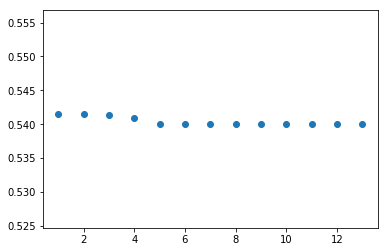

In [28]:
x = range(1,14)
y = []
for i in range(1,14):
    sol = minimize(fun, np.zeros(3), method='SLSQP', bounds=[(0.,1) for x in range(3)],constraints=cons,options={'maxiter':i})
    y.append(fun(sol.x))
plt.scatter(x,y)

In [29]:
fun([0,1,0])

0.5401267339678203

In [30]:
fun(sol.x)

0.5399675639728748

In [31]:
df_data['second_layer'] = second_layer

In [32]:
df = pd.DataFrame(confusion_matrix(y_all, second_layer),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
print(classification_report(y_all, second_layer))
df

              precision    recall  f1-score   support

           1       0.54      0.66      0.59       403
           2       0.57      0.19      0.28       175
           3       0.72      0.43      0.54       406
           4       0.00      0.00      0.00        62
           5       0.52      0.76      0.62       554

   micro avg       0.56      0.56      0.56      1600
   macro avg       0.47      0.41      0.41      1600
weighted avg       0.56      0.56      0.53      1600



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,266,11,21,0,105
Phase 2,44,33,13,0,85
Phase 3,87,4,175,0,140
Phase 4,0,1,4,0,57
Phase 5,95,9,30,0,420


In [33]:
with open(os.path.join(data_path,'classifier_svm_linear_combination_svc_ba_cw_{}.pickle'.format(CLASS_W)),'wb') as f:
    pickle.dump(svc,f)
    pickle.dump(coeff,f)
    pickle.dump(t,f)

In [34]:
t

0.45

In [35]:
df_data.to_excel(os.path.join(tables_path,'[second_layer]'+file_name))

In [36]:
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_all, y_all)))

Accuracy of SVM classifier on training set: 0.51
